# Attention Networks

The tutorial will cover the following:

* Preparing a simple dataset for time series forecasting
* How to use a network built via SimpleRNN for time series forecasting
* Adding a custom attention layer to the SimpleRNN network

In [1]:
from pandas import read_csv
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

### The Dataset

We will create a fibonacci sequence dataset for our purpose. In Fibonacci sequence, one number is constructed from the previous two numbers. The first 10 numbers of the sequence are shown below:

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, …


When given the previous ‘t’ numbers, can you get a machine to accurately reconstruct the next number? This would mean discarding all the previous inputs except the last two and performing the correct operation on the last two numbers.

For this tutorial, you’ll construct the training examples from t time steps and use the value at t+1 as the target. For example, if t=3, then the training examples and the corresponding target values would look as follows:


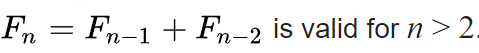
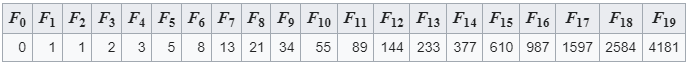

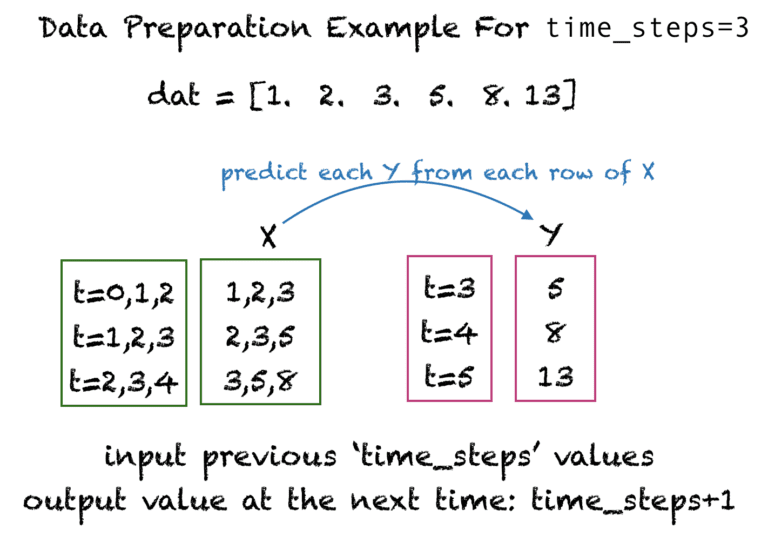

In [2]:
# Prepare data
def get_fib_seq(n, scale_data=True):
    # Get the Fibonacci sequence
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0 
    for i in range(n):
            #
            seq[i] = fib_n1+fib_n
            fib_n1=fib_n
            fib_n=seq[i]
            #
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()        
    return seq, scaler



In [3]:
#
# Check if the function works correctly.
#


In [4]:
# Prepare data
def get_fib_seq_check(n, scale_data=True):
    # Get the Fibonacci sequence
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0 
    for i in range(n):
            #
            seq[i] = fib_n1+fib_n
            fib_n1=fib_n
            fib_n=seq[i]
            #
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()        
    return seq, scaler,fib_n



In [5]:
n=4
dat,scaler,fib_N=get_fib_seq_check(n)
print('seq_normalized=',dat,'\n'
      'seq=',dat*(fib_N-1)+1)

seq_normalized= [0.   0.25 0.5  1.  ] 
seq= [1. 2. 3. 5.]


### The following function transforms the fibonacci sequence into training and test dataset.

X and Y looks like the following. From X and Y, we create training and test dataset.

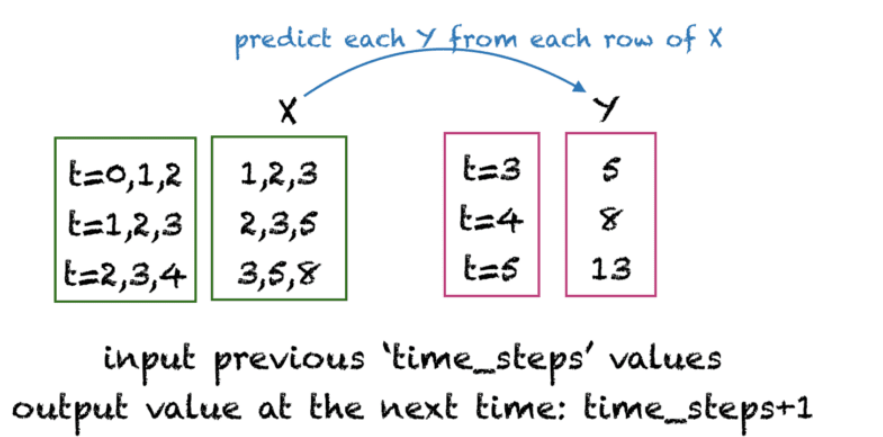

In [6]:
def get_fib_XY(total_fib_numbers, time_steps, train_percent, scale_data=True):
    dat, scaler = get_fib_seq(total_fib_numbers, scale_data) ## Loading the dataset.
    
    #
    #
    # Your code to create training and test dataset. 
    # Note - function argument total_fib_number is the total number of fibonacci numbers, 
    # time_step is the length of the input, 
    # and train_percent determines the ratio of train and test size 
    #   
    #
    Y_ind=np.arange(time_steps,len(dat),1)
    Y=dat[Y_ind]
    rows_x=len(Y)
    X=dat[0:rows_x]
    for i in range(time_steps-1):
        temp=dat[i+1:rows_x+i+1]
        X=np.column_stack((X,temp))
        
    rand=np.random.RandomState(seed=13)
    idx=rand.permutation(rows_x)
    split = int(train_percent*rows_x)
    
    train_ind=idx[0:split]
    test_ind=idx[split:]
    trainX=X[train_ind]
    trainY=Y[train_ind]
    testX=X[test_ind]
    testY=Y[test_ind]
    trainX=np.reshape(trainX,(len(trainX),time_steps,1))
    testX=np.reshape(testX,(len(testX),time_steps,1))
    
        
    return trainX, trainY, testX, testY, scaler


In [7]:
#
# Check if the function works correctly.
#
get_fib_XY(10,3,0.8)

(array([[[0.01136364],
         [0.02272727],
         [0.04545455]],
 
        [[0.04545455],
         [0.07954545],
         [0.13636364]],
 
        [[0.07954545],
         [0.13636364],
         [0.22727273]],
 
        [[0.13636364],
         [0.22727273],
         [0.375     ]],
 
        [[0.22727273],
         [0.375     ],
         [0.61363636]]]),
 array([0.07954545, 0.22727273, 0.375     , 0.61363636, 1.        ]),
 array([[[0.        ],
         [0.01136364],
         [0.02272727]],
 
        [[0.02272727],
         [0.04545455],
         [0.07954545]]]),
 array([0.04545455, 0.13636364]),
 MinMaxScaler())

### In the following code, we test the performance with the help of simple RNN.

In [8]:
# Set up parameters
time_steps = 20
hidden_units = 2
epochs = 30  # or epochs = 40 # if you use GPU or Google Colab

#### Create a traditional RNN network

In [9]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model

In [10]:
model_RNN = create_RNN(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])

In [11]:
#
# Your code to print the model summary
#
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 2)                 8         
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 11 (44.00 Byte)
Trainable params: 11 (44.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
#
# Your code to get the dataset for the network - trainX, trainY, testX, testY, 
# using function get_fib_XY(1200, time_steps, 0.7)
#
trainX,trainY,testX,testY,scaler=get_fib_XY(1200,time_steps,0.7)

In [13]:
history = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/30

826/826 [==============================] - 24s 13ms/step - loss: 1.5936e-04
Epoch 2/30
826/826 [==============================] - 11s 13ms/step - loss: 1.4410e-04
Epoch 3/30
826/826 [==============================] - 11s 13ms/step - loss: 1.1428e-04
Epoch 4/30
826/826 [==============================] - 11s 13ms/step - loss: 1.0603e-04
Epoch 5/30
826/826 [==============================] - 11s 13ms/step - loss: 1.0186e-04
Epoch 6/30
826/826 [==============================] - 11s 14ms/step - loss: 9.4500e-05
Epoch 7/30
826/826 [==============================] - 11s 14ms/step - loss: 9.3130e-05
Epoch 8/30
826/826 [==============================] - 11s 13ms/step - loss: 9.2183e-05
Epoch 9/30
826/826 [==============================] - 12s 14ms/step - loss: 8.7539e-05
Epoch 10/30
826/826 [==============================] - 11s 14ms/step - loss: 8.6921e-05
Epoch 11/30
826/826 [==============================] - 11s 14ms/step - loss: 8.2746e-05
Epoch 12/30
826/826 [===================

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-darkgrid')

C:\Users\SreevaniPaipuru\AppData\Local\Temp\ipykernel_2728\1046343878.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


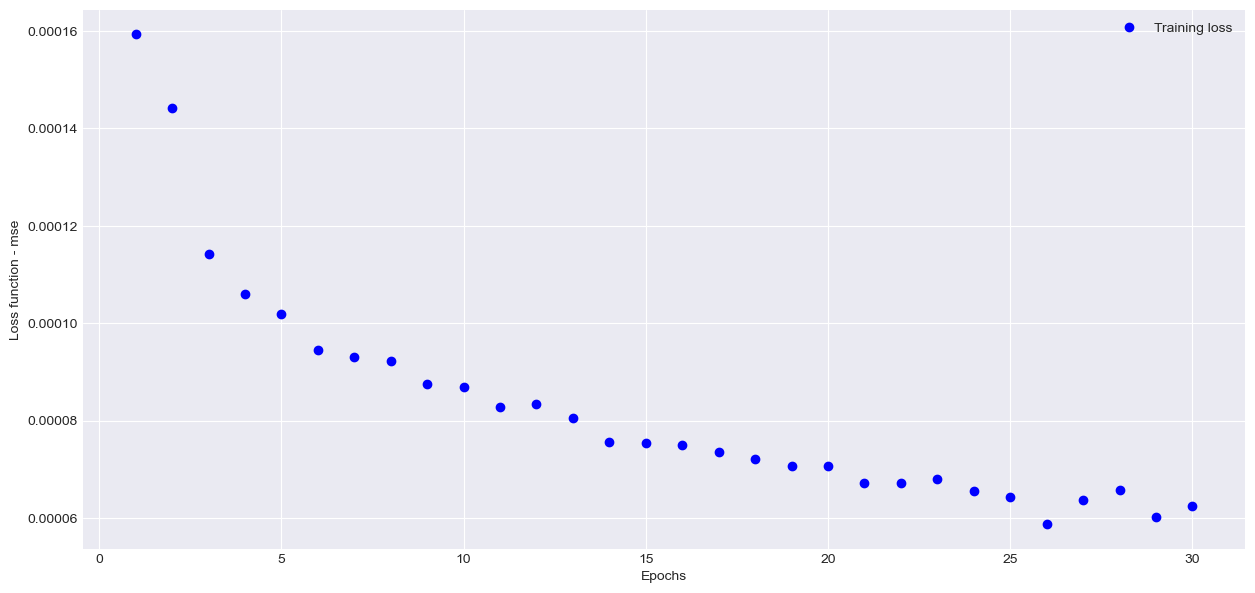

In [15]:
# Training chart

history_dict = history.history

losses = history_dict['loss']
Epochs = range(1, len(losses) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs, losses, 'bo', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

In [16]:
# Evalute model
train_mse = model_RNN.evaluate(trainX, trainY)
test_mse = model_RNN.evaluate(testX, testY)

# Print train and test error metrics
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

12/12 [==============================] - 0s 11ms/step - loss: 2.0493e-05
Train set MSE =  4.964592517353594e-05
Test set MSE =  2.0492743715294637e-05


### The following code creates an attention layer. You need to understand each line to know how an attention layer can be created. 

In [17]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
    


### The following code develops and RNN with attention layer to predict the fibonacci sequence.

In [18]:
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)

    attention_layer = attention()(RNN_layer) ## Note = Attention layer is added here.

    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')    
    return model    


In [19]:
#
# Your code to create the model with attention. Use activation function 'tanh' and
# function 'create_RNN_with_attention'
#
model_attention=create_RNN_with_attention(hidden_units=hidden_units,dense_units=1,
                                         input_shape=(time_steps,1),activation='tanh')

In [20]:
#
# Your code to print the model summary
#
model_attention.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 2)             8         
                                                                 
 attention (attention)       (None, 2)                 22        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 33 (132.00 Byte)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#
# Your code to fit the model
# save the results of the training to 'history_2' variable list
# use batch_size=1
#
history_2=model_attention.fit(trainX,trainY,epochs=epochs,batch_size=1,verbose=1)

Epoch 1/30
826/826 [==============================] - 26s 14ms/step - loss: 0.0010
Epoch 2/30
826/826 [==============================] - 11s 13ms/step - loss: 9.5579e-04
Epoch 3/30
826/826 [==============================] - 11s 14ms/step - loss: 9.1182e-04
Epoch 4/30
826/826 [==============================] - 11s 14ms/step - loss: 8.5344e-04
Epoch 5/30
826/826 [==============================] - 11s 13ms/step - loss: 7.8720e-04
Epoch 6/30
826/826 [==============================] - 11s 14ms/step - loss: 7.4323e-04
Epoch 7/30
826/826 [==============================] - 11s 14ms/step - loss: 6.6724e-04
Epoch 8/30
826/826 [==============================] - 11s 14ms/step - loss: 5.9371e-04
Epoch 9/30
826/826 [==============================] - 12s 14ms/step - loss: 5.2389e-04
Epoch 10/30
826/826 [==============================] - 11s 14ms/step - loss: 4.4545e-04
Epoch 11/30
826/826 [==============================] - 12s 15ms/step - loss: 3.8120e-04
Epoch 12/30
826/826 [========================

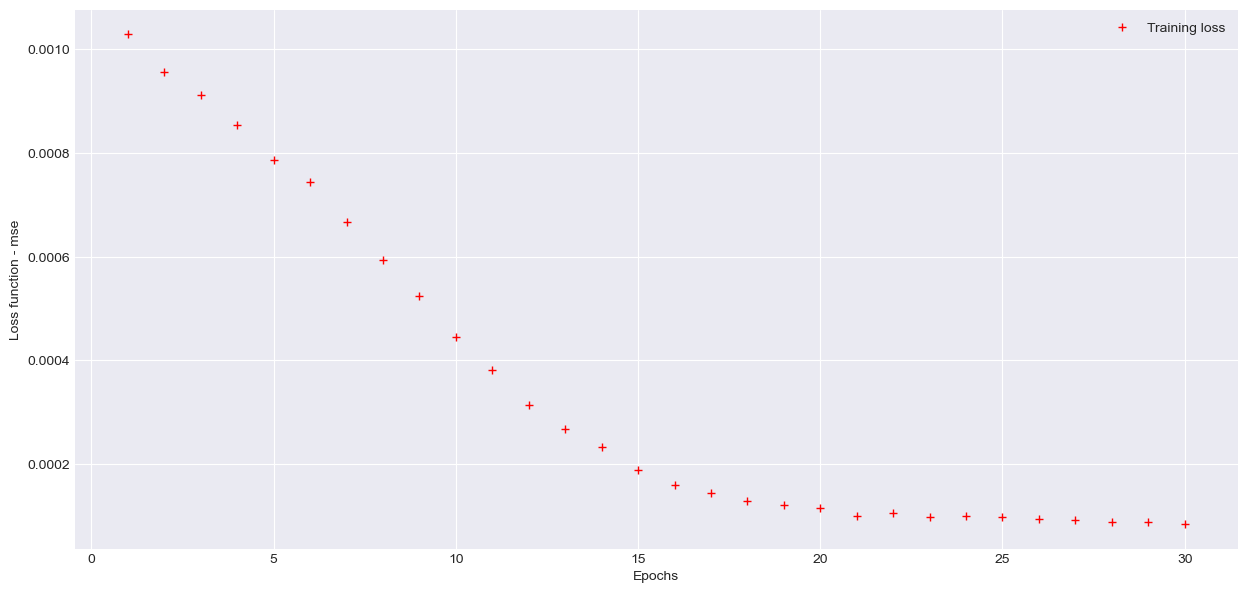

In [22]:
#
# your code to drow the Training chart
#


history_dict=history_2.history
losses=history_dict['loss']
Epochs=range(1,len(losses)+1)
plt.figure(num=1,figsize=(15,7))
plt.plot(Epochs,losses,'r+',label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

In [23]:
#
# your code to Evaluate attention model on training set
# Your code to evaluate the attention model on test set
#
train_mse_attn=model_attention.evaluate(trainX,trainY)
test_mse_attn=model_attention.evaluate(testX,testY)

12/12 [==============================] - 0s 24ms/step - loss: 8.8236e-06


In [24]:
#
# Your code to print train error metric
# Your code to print test error metric
#
print("Train set MSE with attention = ",train_mse_attn)
print("Test set MSE with attention = ",test_mse_attn)

Train set MSE with attention =  6.417698750738055e-05
Test set MSE with attention =  8.823581993055996e-06


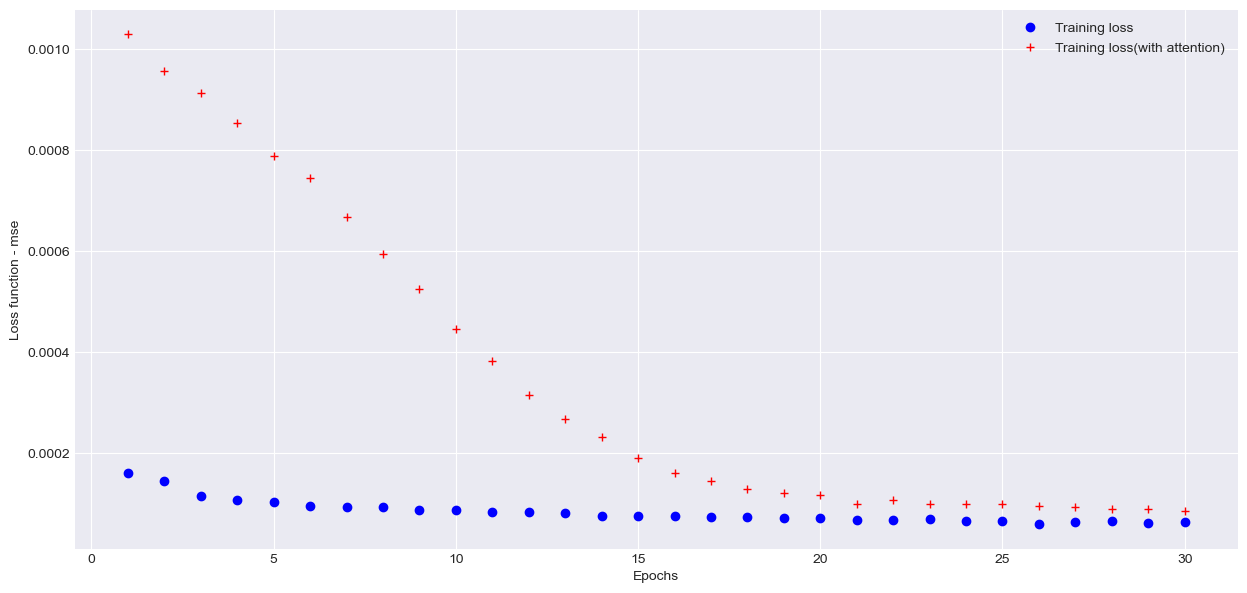

In [25]:
# Training chart

history_dict_1 = history.history
history_dict_2=history_2.history

losses_1 = history_dict_1['loss']
losses_2=history_dict_2['loss']

Epochs = range(1, len(losses_1) + 1)

plt.figure(num=1, figsize=(15,7))

plt.plot(Epochs, losses_1, 'bo', label='Training loss')
plt.plot(Epochs,losses_2,'r+',label='Training loss(with attention)')
plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

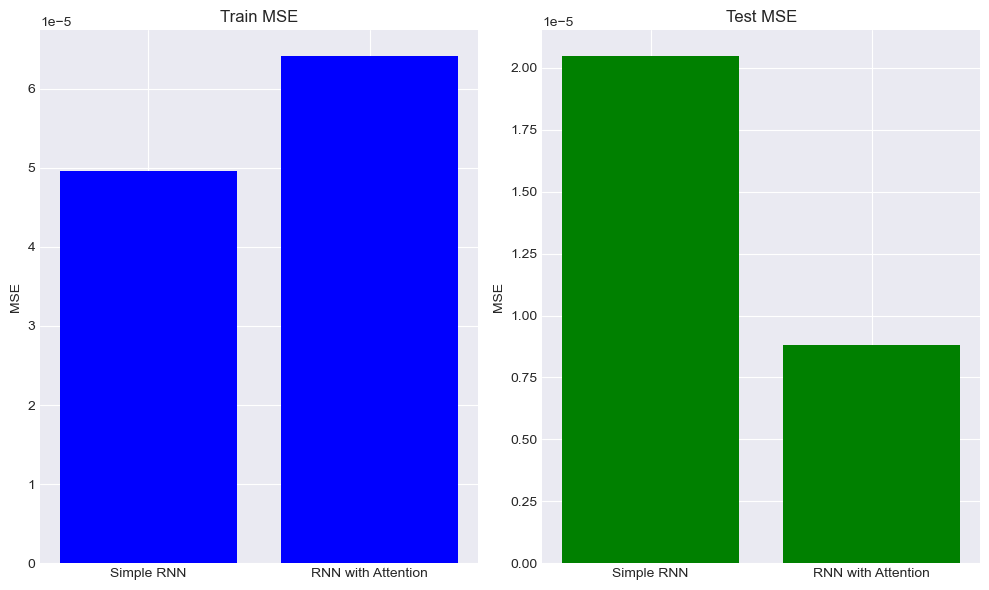

In [26]:
import matplotlib.pyplot as plt

# Define the model names
model_names = ['Simple RNN', 'RNN with Attention']

# Define the train and test MSE values for both models
train_mse_values = [train_mse, train_mse_attn]
test_mse_values = [test_mse, test_mse_attn]

# Plot the train and test MSE for both models
plt.figure(figsize=(10, 6))

# Plot train MSE
plt.subplot(1, 2, 1)
plt.bar(model_names, train_mse_values, color='blue')
plt.title('Train MSE')
plt.ylabel('MSE')

# Plot test MSE
plt.subplot(1, 2, 2)
plt.bar(model_names, test_mse_values, color='green')
plt.title('Test MSE')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()

# Lab Logbook requirement: Document the following in Lab Logbook

## Plot the model's performance of the train and test MSE for the 'Simple RNN' and 'RNN with an attention layer'.

### Ensure that no code or other information is added to the logbook and that only required information is present.  Marks will not be awarded if anything else is found in the logbook or instructions are not clearly followed.
### NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK ON GITHUB OR ONEDRIVE.

## Challenges (Optional): Test the above model with different parameters, layer size, train and test ratio, and time steps.